In [1]:
# Import necessary libraries
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import seaborn as sns


In [41]:
# Setting font sizes for consistent and readable plots
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

# Customizing matplotlib's default settings for font sizes
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [13]:
# Loading the dataset
tdf = pd.read_csv('../out/results/final_datasets/trends_data2.csv')

# Reads a CSV file from the specified path into a pandas DataFrame called `tdf`.
# The file path points to a dataset located in a relative directory.

In [16]:
# Get the maximum value for each column in the DataFrame `tdf`
tdf.max(axis=0)

subject_id                            sub_9999
site_id                               site4802
sex                                          1
parental_education                           3
iq                                         156
autism_diagnosis                             1
wave_number                                  7
age                                        251
cbcl_externalizing_raw_score                28
cbcl_internalizing_raw_score                33
cbcl_attentionproblem_raw_score             20
wm_volume                          639345.6592
gm_volume                          852844.6092
frontal_lobe_gm_thickness             3.158059
hippo_volume                       11924.82184
amygdala_volume                    5733.614722
icv                                2156988.564
dob                                 2009-01-01
brain_behavior_measurement_date     2029-12-01
dtype: object

In [6]:
# Replace specific placeholder values in the columns 'gm_volume' and 'wm_volume' with a valid alternative
tdf['gm_volume'].replace(1000000, 999999, inplace=True)
tdf['wm_volume'].replace(1000000, 999999, inplace=True)


In [17]:
# Get the maximum value in the 'site_id' column
tdf['site_id'].max()

'site4802'

In [9]:
# Save the modified DataFrame `tdf` to a new CSV file
tdf.to_csv('../out/results/final_datasets/trends_data3.csv')

## Data Preparation 

In [2]:
# Define data entries for categorization 
misc_entries = ['subject_id', 'site_id', 'event'] #  Identifiers and event labels
static_entries = ['sex','parental_education', 'iq','ASD', 'wave_number'] # Static variables (constant over time)
dynamic_entries = ['age','cbcl_externalizing_raw_score', 'cbcl_internalizing_raw_score', 'cbcl_attentionproblem_raw_score', 'wm_volume','gm_volume','frontal_lobe_gm_thickness','hippo_volume', 'amygdala_volume', 'icv'] # Time-varying variables


# Specify entries used for model input and output
x_entries = static_entries  # Input features
t_entry = 'age'  # Time variable
y_entries = ['cbcl_externalizing_raw_score', 'cbcl_internalizing_raw_score', 'cbcl_attentionproblem_raw_score', 'wm_volume','gm_volume','frontal_lobe_gm_thickness','hippo_volume', 'amygdala_volume', 'icv']  # Output targets


In [ ]:

# Load data 
raw_df = pd.read_excel('../data/trainingSetFull_v4.xlsx')

In [ ]:
# Display the contents of the raw dataset
raw_df

### Data Properties

In [ ]:
# Count missing values for 'Baseline' events
raw_df.loc[raw_df['event'] == 'Baseline'].isnull().sum(axis=0)

In [ ]:
# Count missing values for 'Twoyear' events
raw_df.loc[raw_df['event'] == 'Twoyear'].isnull().sum(axis=0)

In [ ]:
# Count missing values for 'Fouryear' events
raw_df.loc[raw_df['event'] == 'Fouryear'].isnull().sum(axis=0)

### Fill missing follow-up values 

In [ ]:
# Create a copy of the dataset to avoid altering the original
newdf = raw_df.copy()

# Fill missing values in follow-up rows with baseline (for static variables)
for sub in np.unique(newdf['subject_id'].values):
    curval = newdf.loc[newdf['subject_id'] == sub]
    for sv in static_entries:
        baseline_val = curval.loc[curval['event']=='Baseline'][sv]
        if len(baseline_val > 0):
            curval.loc[:,sv] = baseline_val.values[0]
    newdf.loc[newdf['subject_id']==sub] = curval 
newdf.to_excel('../data/trainingSetFull_v4_filled.xlsx')


In [ ]:
# Verify that missing values are filled for 'Baseline', 'Twoyear', and 'Fouryear' events
newdf.loc[newdf['event'] == 'Baseline'].isnull().sum(axis=0)

In [ ]:
newdf.loc[newdf['event'] == 'Twoyear'].isnull().sum(axis=0)

In [ ]:
newdf.loc[newdf['event'] == 'Fouryear'].isnull().sum(axis=0)

### Load Data

In [3]:
# Load another version of the dataset for further processing
indf = pd.read_excel('../data/trainingSetFull_v5_filled.xlsx')

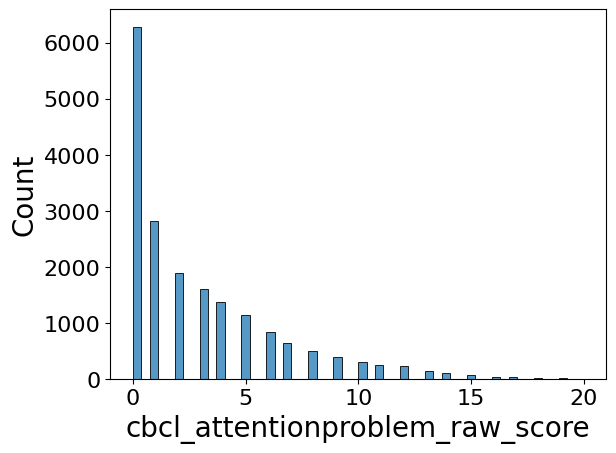

In [40]:
# Plot the distribution of the 'cbcl_attentionproblem_raw_score' variable
sns.histplot(data=indf, x='cbcl_attentionproblem_raw_score')
plt.show()

In [4]:
# Tune age to be in the range of simulated dataset
desired_age_range = 252-84
abcd_age_range = 187-107
indf['age'] = (indf['age'] - 107) * (desired_age_range/abcd_age_range) + 84

In [5]:
# Tune parental education and frontal_lobe_gm_thickness to be at the same scale as simulated dataset
indf['parental_education']  /= 7
indf['frontal_lobe_gm_thickness'] /= 22

In [25]:
# Display the column names in the processed dataset
indf.columns

Index(['Unnamed: 0', 'subject_id', 'event', 'wave_number', 'site_id', 'age',
       'cbcl_externalizing_raw_score', 'cbcl_internalizing_raw_score',
       'cbcl_attentionproblem_raw_score', 'hippo_volume', 'amygdala_volume',
       'icv', 'iq', 'sex', 'parental_education', 'frontal_lobe_gm_thickness',
       'ASD', 'wm_volume', 'gm_volume'],
      dtype='object')

In [32]:
indf.mean(axis=0).to_csv('../out/ABCDmean.csv', float_format='%.2f')

/data/users4/ibatta/venv/conda/anaconda/envs/AA_DL2/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [6]:
indf.max(axis=0)

Unnamed: 0                                   20733
subject_id                         NDARINVZZZP87KR
event                                      Twoyear
wave_number                                      3
site_id                                     site22
age                                          252.0
cbcl_externalizing_raw_score                  50.0
cbcl_internalizing_raw_score                  51.0
cbcl_attentionproblem_raw_score               20.0
hippo_volume                               13623.3
amygdala_volume                             6414.5
icv                                 2155652.711177
iq                                           221.0
sex                                            1.0
parental_education                             3.0
frontal_lobe_gm_thickness                 3.203455
ASD                                            1.0
wm_volume                                   672091
gm_volume                                   809201
dtype: object

In [7]:
indf.min(axis=0)

Unnamed: 0                                       0
subject_id                         NDARINV003RTV85
event                                     Baseline
wave_number                                      1
site_id                                     site01
age                                           84.0
cbcl_externalizing_raw_score                   0.0
cbcl_internalizing_raw_score                   0.0
cbcl_attentionproblem_raw_score                0.0
hippo_volume                                4140.8
amygdala_volume                             1794.7
icv                                  940227.548716
iq                                            32.0
sex                                            0.0
parental_education                        0.142857
frontal_lobe_gm_thickness                 2.210227
ASD                                            0.0
wm_volume                                        0
gm_volume                                        0
dtype: object

In [8]:
indf.loc[indf['event'] == 'Baseline'].isnull().sum(axis=0)

Unnamed: 0                           0
subject_id                           0
event                                0
wave_number                          0
site_id                              0
age                                  0
cbcl_externalizing_raw_score         6
cbcl_internalizing_raw_score         6
cbcl_attentionproblem_raw_score      6
hippo_volume                         0
amygdala_volume                      0
icv                                  0
iq                                 391
sex                                  0
parental_education                  17
frontal_lobe_gm_thickness            0
ASD                                 39
wm_volume                            0
gm_volume                            0
dtype: int64

In [9]:
indf.loc[indf['event'] == 'Twoyear'].isnull().sum(axis=0)

Unnamed: 0                            0
subject_id                            0
event                                 0
wave_number                           0
site_id                               0
age                                   0
cbcl_externalizing_raw_score       1150
cbcl_internalizing_raw_score       1150
cbcl_attentionproblem_raw_score    1150
hippo_volume                          0
amygdala_volume                       0
icv                                   0
iq                                  390
sex                                 139
parental_education                  152
frontal_lobe_gm_thickness             0
ASD                                  30
wm_volume                             0
gm_volume                             0
dtype: int64

In [10]:
indf.loc[indf['event'] == 'Fouryear'].isnull().sum(axis=0)

Unnamed: 0                          0
subject_id                          0
event                               0
wave_number                         0
site_id                             0
age                                 0
cbcl_externalizing_raw_score       11
cbcl_internalizing_raw_score       11
cbcl_attentionproblem_raw_score    11
hippo_volume                        0
amygdala_volume                     0
icv                                 0
iq                                 84
sex                                19
parental_education                 19
frontal_lobe_gm_thickness           0
ASD                                21
wm_volume                           0
gm_volume                           0
dtype: int64

In [11]:
indf

,Unnamed: 0,subject_id,event,wave_number,site_id,age,cbcl_externalizing_raw_score,cbcl_internalizing_raw_score,cbcl_attentionproblem_raw_score,hippo_volume,amygdala_volume,icv,iq,sex,parental_education,frontal_lobe_gm_thickness,ASD,wm_volume,gm_volume
0,0,NDARINV003RTV85,Baseline,1,site06,134.4,1.0,1.0,1.0,7547.0,3695.6,1.325997e+06,99.0,1.0,1.857143,2.822273,0.0,333908,547265
1,1,NDARINV005V6D2C,Baseline,1,site10,113.4,0.0,1.0,0.0,7927.1,3266.9,1.255721e+06,91.0,1.0,0.857143,2.628500,0.0,352619,518906
2,2,NDARINV007W6H7B,Baseline,1,site22,123.9,2.0,8.0,4.0,10160.0,4243.0,1.677465e+06,114.0,0.0,2.714286,2.877227,0.0,470745,657068
3,3,NDARINV00BD7VDC,Baseline,1,site07,94.5,3.0,5.0,5.0,8904.2,3510.8,1.639089e+06,110.0,0.0,2.857143,2.802727,0.0,466049,715794
4,4,NDARINV00CY2MDM,Baseline,1,site20,132.3,18.0,5.0,10.0,7845.0,3602.9,1.516595e+06,95.0,0.0,2.142857,2.823409,0.0,418217,562628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20729,20729,NDARINVZZZ2ALR6,Twoyear,2,site08,163.8,0.0,2.0,0.0,8883.2,3776.0,1.518578e+06,133.0,1.0,3.000000,2.812636,0.0,447576,599445
20730,20730,NDARINVZZZNB0XC,Baseline,1,site03,86.1,4.0,2.0,3.0,8271.0,3552.4,1.437670e+06,NaN,1.0,2.714286,2.955409,0.0,377837,566786
20731,20731,NDARINVZZZNB0XC,Fouryear,3,site03,189.0,0.0,3.0,2.0,8388.0,3578.8,1.413259e+06,NaN,1.0,2.714286,2.871727,0.0,402591,569886
20732,20732,NDARINVZZZP87KR,Baseline,1,site19,123.9,0.0,3.0,1.0,8613.9,3757.6,1.490073e+06,NaN,1.0,2.428571,2.891636,0.0,412198,593728


### Drop or Impute NaN or missing values

In [12]:

# raw_df['autism_diagnosis']  = np.random.randint(2, size=n_samp)


# Impute or drop entries with missing values
indf.dropna(inplace=True)

# imputed_data = IterativeImputer().fit_transform(indf[static_entries + y_entries].values)
# indf.loc[:,static_entries + y_entries] = imputed_data


In [13]:
indf

,Unnamed: 0,subject_id,event,wave_number,site_id,age,cbcl_externalizing_raw_score,cbcl_internalizing_raw_score,cbcl_attentionproblem_raw_score,hippo_volume,amygdala_volume,icv,iq,sex,parental_education,frontal_lobe_gm_thickness,ASD,wm_volume,gm_volume
0,0,NDARINV003RTV85,Baseline,1,site06,134.4,1.0,1.0,1.0,7547.0,3695.6,1.325997e+06,99.0,1.0,1.857143,2.822273,0.0,333908,547265
1,1,NDARINV005V6D2C,Baseline,1,site10,113.4,0.0,1.0,0.0,7927.1,3266.9,1.255721e+06,91.0,1.0,0.857143,2.628500,0.0,352619,518906
2,2,NDARINV007W6H7B,Baseline,1,site22,123.9,2.0,8.0,4.0,10160.0,4243.0,1.677465e+06,114.0,0.0,2.714286,2.877227,0.0,470745,657068
3,3,NDARINV00BD7VDC,Baseline,1,site07,94.5,3.0,5.0,5.0,8904.2,3510.8,1.639089e+06,110.0,0.0,2.857143,2.802727,0.0,466049,715794
4,4,NDARINV00CY2MDM,Baseline,1,site20,132.3,18.0,5.0,10.0,7845.0,3602.9,1.516595e+06,95.0,0.0,2.142857,2.823409,0.0,418217,562628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20723,20723,NDARINVZZLZCKAY,Twoyear,2,site06,134.4,7.0,17.0,4.0,7892.6,3577.4,1.496677e+06,94.0,1.0,2.142857,2.829909,0.0,372519,557920
20726,20726,NDARINVZZPKBDAC,Baseline,1,site12,96.6,0.0,1.0,0.0,8929.8,3704.3,1.461748e+06,106.0,1.0,2.714286,2.891955,0.0,338910,543148
20727,20727,NDARINVZZPKBDAC,Twoyear,2,site12,144.9,0.0,1.0,1.0,9088.8,3851.7,1.484419e+06,106.0,1.0,2.714286,2.869955,0.0,351396,541455
20728,20728,NDARINVZZZ2ALR6,Baseline,1,site08,113.4,4.0,5.0,0.0,8741.6,3674.2,1.450474e+06,133.0,1.0,3.000000,2.857182,0.0,425259,592955


In [14]:
# Prepare input arrays for the model
t = np.expand_dims(indf['age'].values, axis=-1)
x = indf[x_entries].to_numpy()
ydf = indf[y_entries]
# y['hippo_volume'] = indf['hippo_volume'].values + dummy_poly_add(t.squeeze(), 1-x[:,2].squeeze(), cx_alpha=0.5 ).squeeze()
y = ydf.to_numpy().astype(float)



## Visualize data 

In [ ]:
# Visualize the relationship between 'age' and target variables
# huevar = 'sex'
# cdict = {0:'red',1:'blue',2:'green'}
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,16))
for yind in range(len(y_entries)):
    i = yind // 3 
    j = yind % 3 
    sns.regplot(data = indf, x='age',y=y_entries[yind], ax=ax[i,j], scatter_kws={'s':0.1})#, color=[cdict[np.floor(i)] for i in indf[huevar].values])
    # ax[i,j].scatter(t, y[:,yind], s=2, color='gray')
    # ax[i,j].set_xlabel(y_entries[yind])
plt.savefig('../out/data_vis_ABCD_v4_dropna.png')
plt.close(f)

## Training Models

___
### Model 2 (polynomial with interaction with x)


t : age \
y: variables that change with age, i.e. brain measures (total GMV etc.) and cognitive assessments (IQ, CSRB score)  \
x: static variables (sex, ASD, parental education etc.)  + additional dimension (=1 only in case of model 2., 3.) \


$ y_i=f(x,t ; α,β,γ)= α_1^T x t+ α_2^T x t^2+β^T x+γ $

In [56]:
from sklearn.model_selection import train_test_split

# Define a function to transform input data by adding interaction and polynomial terms
def transform2(x,t):
    xnew = np.append(x, np.ones(t.shape), -1)
    const = np.ones(t.shape)
    return np.hstack((xnew*t,xnew*(t**2),xnew,const))


# Transform inputs for training
cur_in = transform2(x,t)

# Split the data into training and testing sets
in_train, in_test, y_train, y_test = train_test_split(cur_in, y, test_size=0.1)

# Train a multi-output regression model
regr = MultiOutputRegressor(LinearRegression(positive=False), n_jobs=4).fit(in_train, y_train)
test_pred = regr.predict(in_test)

In [57]:
# Evaluate the model using various performance metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr

def compute_performance_metrics(y_test, test_pred):
    mae = mean_absolute_error(y_test, test_pred, multioutput='raw_values')
    datarange = np.ptp(y_test, axis=0)
    nrmse = ((mean_squared_error(y_test, test_pred, multioutput='raw_values'))**0.5) / datarange
    r2 = r2_score(y_test, test_pred, multioutput='raw_values')
    return mae, nrmse, r2

In [58]:
metrics = compute_performance_metrics(y_test, test_pred)
mae, nrmse, r2 = metrics
mae, nrmse, r2

(array([3.97134490e+00, 4.07061677e+00, 2.49924335e+00, 3.12241345e+04,
        3.62230388e+04, 6.91611529e-02, 5.80052992e+02, 3.14412622e+02,
        1.00265798e+05]),
 array([0.11724599, 0.11223657, 0.17148754, 0.06405397, 0.06146587,
        0.10075087, 0.1125892 , 0.11460228, 0.12190153]),
 array([0.03767383, 0.00742901, 0.07812513, 0.29107455, 0.26082598,
        0.06722148, 0.18349136, 0.17205527, 0.28975718]))

In [59]:
mae.shape

(9,)

In [60]:
# Plot the performance metrics for visualization
def plot_performace_metrics(metrics, outfile_prefix):
    mae, nrmse, r2 = metrics
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(36,6))
    xvals = np.array(list(range(len(y_entries))))
    
     # Plot Mean Absolute Error
    ax[0].bar(x=xvals, height=mae)
    ax[0].set_xticks(xvals)
    ax[0].set_xticklabels(y_entries, rotation=90)
    ax[0].set_ylabel('MAE')

    # Plot Normalized RMSE
    ax[1].bar(x=xvals, height=nrmse)
    ax[1].set_xticks(xvals)
    ax[1].set_xticklabels(y_entries, rotation=90)
    ax[1].set_ylabel('NRMSE')

     # Plot R-squared values
    ax[2].bar(x=xvals, height=r2)
    ax[2].set_xticks(xvals)
    ax[2].set_xticklabels(y_entries, rotation=90)
    ax[2].set_ylabel('R2')
    plt.suptitle('Prediction performance (%s)'%outfile_prefix)
    plt.savefig('../out/%s.png'%outfile_prefix, bbox_inches='tight')
    plt.close(f)


In [61]:
plot_performace_metrics(metrics, 'model_2_performace_ABCD_stretched_bigfont')

In [68]:
# Scatter plot: real vs predicted values
def scatterplot_realVSpredicted(x,t,y,model,outfile_prefix):
    cur_in = transform2(x,t)
    for xind in range(len(x_entries)):
        f, ax = plt.subplots(nrows=3, ncols=3, figsize=(32,18))

        # i1 = np.arange(t.min(),t.max(),0.1)
        for yind in range(len(y_entries)):
        # yind = -3
            i, j = yind // 3, yind % 3 
            
            ax[i,j].scatter(t, y[:,yind], s=2, color='gray')

            # plt.plot(t[x[:,xind]==0], regr.predict(cur_in[x[:,xind]==0,:])[:,yind], color='green', label=x_entries[xind]+"=0")
            # plt.plot(t[x[:,xind]==1], regr.predict(cur_in[x[:,xind]==1,:])[:,yind], color='red',  label=x_entries[xind]+"=1")
            
            # sns.regplot(x = t[x[:,xind]==0], y = regr.predict(cur_in[x[:,xind]==0,:])[:,yind], scatter_kws={'s':1}, color='green', label=x_entries[xind]+"=0", fit_reg=False, ax=ax[i,j])
            # sns.regplot(x = t[x[:,xind]==1], y = regr.predict(cur_in[x[:,xind]==1,:])[:,yind], scatter_kws={'s':1}, color='red', label=x_entries[xind]+"=1", fit_reg=False, ax=ax[i,j])
            
            # sns.regplot(x = t[x[:,xind]==0], y = regr.predict(cur_in[x[:,xind]==0,:])[:,yind], scatter_kws={'s':1}, color='green', label=x_entries[xind]+"=0", fit_reg=False, ax=ax[i,j])
            sns.scatterplot(x = t.squeeze(), y = model.predict(cur_in)[:,yind].squeeze(), hue=x[:,xind].squeeze(), ax=ax[i,j], alpha=0.9)

            
            ax[i,j].legend()
            ax[i,j].set_ylabel(y_entries[yind])
            ax[i,j].set_xlabel('age (months)')
        
        plt.suptitle(x_entries[xind])
        plt.savefig('../out/%s_%s.png'%(outfile_prefix,x_entries[xind]), bbox_inches='tight')
        print(x_entries[xind])
        plt.close(f)

In [69]:
scatterplot_realVSpredicted(x,t,y,regr,'model_2_ABCD_stretched_bigfont')

sex
parental_education
iq
ASD
wave_number


Model 2 is able to capture the change in polynomial effects due to the different values in the static variables. 

### Covariance estimates 

In [15]:
# Estimate the covariance matrix (C) and correlation coefficient matrix (Rho) for the response variable matrix (y)
C = np.cov(y.T)
Rho = np.corrcoef(y.T)  # Correlation coefficient matrix of y (normalized covariance matrix)

# Compute the standard deviation for each feature in y, reshaped for broadcasting
std = np.expand_dims(np.std(y.T,axis=1), axis = -1)

In [74]:
## add artificial covariance for other two datasets
def perturb_corr(R):
    addon = (np.tril(np.random.random(R.shape), k=-1) / 5) - 0.2
    Rho_new = R + ((addon + addon.T) * (np.abs(Rho)<0.8))
    return Rho_new

# Create a perturbed correlation matrix for the first artificial dataset
Rho1 = perturb_corr(Rho)
C1 = Rho1 * (std @ std.T)

# Create a second perturbed correlation matrix for another artificial dataset
Rho3 = perturb_corr(Rho)
C3 = Rho3 * (std @ std.T)


In [75]:
# Define a utility function to check if a matrix is symmetric within a given tolerance
def check_symmetric(a, tol=1e-6):
    return np.all(np.abs(a-a.T) < tol)
print(check_symmetric(C3))
print(check_symmetric(C3))


True
True


In [17]:
# Plot a heatmap of the original correlation coefficient matrix (Rho)
plt.close()
f, ax = plt.subplots()
sns.heatmap( data=Rho, cbar=True , ax = ax) 
ax.set_title('correlation')
ax.set_xticklabels(y_entries, rotation=90)
plt.savefig('../out/tempCorr.png', bbox_inches='tight')
plt.close(f)

## Generating Simulated Data 

### Simulation Functions

In [76]:

# Function to create synthetic data for model training and testing
def gen_data(n_sub=10000, n_waves=7, dummy=False):
    # generate dummy data for learning the model (to be later replaced with real dataset)
    
    outdf = pd.DataFrame(columns = misc_entries + static_entries + dynamic_entries)

    sub_ids = ['sub_%d'%i for i in range(n_sub)]
    sex_vals = np.random.randint(2, size=n_sub)
    asd_vals = np.random.randint(2, size=n_sub)
    parental_edu_vals = np.random.choice(4, size=n_sub, p = [0.05, 0.35, 0.25, 0.35])
    iq_vals = np.round( np.random.normal(100, 15, size=n_sub) )
    
    for wvn in range(n_waves):
        
        df = pd.DataFrame(columns = misc_entries + static_entries + dynamic_entries)
        df['wave_number'] = np.repeat(wvn + 1, n_sub)
        df['subject_id'] = sub_ids
        df['age'] = 84 + wvn*24 + np.random.randint(24, size=n_sub) # 
        df['sex'] = sex_vals
        df['ASD']  = asd_vals
        df['parental_education'] = parental_edu_vals
        df['iq'] = iq_vals
        
        if dummy:
            df['cbcl_externalizing_raw_score'] = np.round( np.random.normal(20, 5, size=n_sub) )
            df['cbcl_internalizing_raw_score'] = np.round( np.random.normal(20, 4, size=n_sub) )
            df['cbcl_attentionproblem_raw_score'] = np.round( np.random.normal(8, 3, size=n_sub) )
            df['gm_volume'] = np.random.normal(500000, 50000, size=n_sub)
            df['wm_volume'] = np.random.normal(400000, 40000, size=n_sub)
            df['hippo_volume'] = np.random.normal(8000, 1000, size=n_sub)
            df['amygdala_volume'] = np.random.normal(4000, 500, size=n_sub)
            df['frontal_lobe_gm_thickness'] = np.random.normal(3.5, 0.2, size=n_sub)
            df['icv'] = np.random.normal(1500000, 150000, size=n_sub)
        
        outdf = outdf.append(df)
        
    return outdf 

In [77]:
newdf = gen_data()

In [78]:
newdf

,subject_id,site_id,event,sex,parental_education,iq,ASD,wave_number,age,cbcl_externalizing_raw_score,cbcl_internalizing_raw_score,cbcl_attentionproblem_raw_score,wm_volume,gm_volume,frontal_lobe_gm_thickness,hippo_volume,amygdala_volume,icv
0,sub_0,NaN,NaN,0,1,92.0,0,1,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub_1,NaN,NaN,1,1,99.0,1,1,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub_2,NaN,NaN,1,3,127.0,0,1,103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub_3,NaN,NaN,0,1,107.0,0,1,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub_4,NaN,NaN,1,1,88.0,1,1,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,sub_9995,NaN,NaN,0,2,81.0,1,7,246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,sub_9996,NaN,NaN,0,2,110.0,0,7,245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,sub_9997,NaN,NaN,1,2,128.0,1,7,246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,sub_9998,NaN,NaN,0,0,86.0,1,7,239,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
# Data cloud around origin spread according to Covariance C. 
# Generate baseline cloud with zero mean for single wave to be replicated (with or without perturbations for other waves)

single_wave = np.random.multivariate_normal(np.zeros(y.shape[1]), C, size=10000)
single_wave1 = np.random.multivariate_normal(np.zeros(y.shape[1]), C1, size=10000)

In [80]:
single_wave3 = np.random.multivariate_normal(np.zeros(y.shape[1]), C3, size=10000)

/data/users4/ibatta/venv/conda/anaconda/envs/AA_DL2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [81]:
plt.close()
f, ax = plt.subplots()
sns.heatmap( data=np.corrcoef(single_wave.T) , cbar=True , ax = ax) 
ax.set_title('correlation in simulated sample')
ax.set_xticklabels(y_entries, rotation=90)
plt.savefig('../out/model_2_ABCDsimulated_stretched_correlations_bigfont.png')
plt.close(f)


### Add Mean values 

In [82]:
# Add mean values to the generated data based on the regressor prediction
x_new = newdf[x_entries].to_numpy()
t_new = np.expand_dims(newdf['age'].values, axis=-1)
curin_new = transform2(x_new, t_new)
y_new = regr.predict(curin_new) + np.repeat(single_wave, 7, axis=0)

In [83]:
x1 = newdf[x_entries].to_numpy()
t1 = np.expand_dims(newdf['age'].values, axis=-1)
curin1 = transform2(x1, t1)
y1 = regr.predict(curin1) + np.repeat(single_wave1, 7, axis=0)

In [84]:
# Check dimensions of transformed and predicted data
t_new.shape, x_new.shape, y_new.shape

((70000, 1), (70000, 5), (70000, 9))

### Save simulated data 

In [87]:
newdf[y_entries] = y_new
newdf

,subject_id,site_id,event,sex,parental_education,iq,ASD,wave_number,age,cbcl_externalizing_raw_score,cbcl_internalizing_raw_score,cbcl_attentionproblem_raw_score,wm_volume,gm_volume,frontal_lobe_gm_thickness,hippo_volume,amygdala_volume,icv
0,sub_0,NaN,NaN,0,1,92.0,0,1,93,8.290839,11.174960,-2.383021,299909.039441,503176.463236,2.834376,7174.402923,3471.442488,1.250978e+06
1,sub_1,NaN,NaN,1,1,99.0,1,1,106,10.441970,15.151897,-0.264584,264221.071253,461245.174400,2.829840,6786.785766,3202.249201,1.145379e+06
2,sub_2,NaN,NaN,1,3,127.0,0,1,103,3.965137,9.668514,-4.662487,295671.373118,508060.766544,2.863018,7400.660747,3477.873427,1.257919e+06
3,sub_3,NaN,NaN,0,1,107.0,0,1,104,7.680292,10.937152,-3.037551,307993.607010,510528.468953,2.824455,7306.495190,3515.917216,1.270988e+06
4,sub_4,NaN,NaN,1,1,88.0,1,1,105,10.818191,15.187592,0.145477,259458.524423,455637.042675,2.830651,6701.517224,3172.600087,1.133161e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,sub_9995,NaN,NaN,0,2,81.0,1,7,246,11.545823,6.771007,8.132047,385803.964474,570815.763331,2.818123,8522.152490,3732.615351,1.363466e+06
9996,sub_9996,NaN,NaN,0,2,110.0,0,7,245,7.589887,4.026433,5.727543,367895.759241,545546.390208,2.815112,8524.159802,3533.750329,1.311754e+06
9997,sub_9997,NaN,NaN,1,2,128.0,1,7,246,9.540586,9.969384,7.022533,361263.337853,533571.293777,2.801206,8095.464281,3456.106934,1.197040e+06
9998,sub_9998,NaN,NaN,0,0,86.0,1,7,239,13.396324,10.153607,9.489216,373049.388488,541092.736933,2.804934,7891.132948,3503.464696,1.262304e+06


In [88]:
newdf.to_excel('../out/ABCDsimulated_data_2.xlsx')

In [89]:
newdf[y_entries] = y1
newdf.to_excel('../out/ABCDsimulated_data_1.xlsx')


In [90]:

newdf[y_entries] = y_new


In [91]:
scatterplot_realVSpredicted(x_new,t_new, y_new, regr, 'model_2_ABCDsimulated_stretched_bigfont')

## Fit regressor on simulated data 

In [ ]:
# Fit a regressor to the simulated data
new_train, new_test, ynew_train, ynew_test = train_test_split(curin_new, y_new, test_size=0.1)
regr_new = MultiOutputRegressor(LinearRegression(positive=False), n_jobs=4).fit(new_train, ynew_train)
test_pred_new = regr.predict(new_test)

In [ ]:
# Compute performance metrics for the regressor
metrics_new = compute_performance_metrics(ynew_test, test_pred_new)
mae_new, rmse_new, r2_new = metrics_new
mae_new, rmse_new, r2_new

In [ ]:
# Plot performance metrics
plot_performace_metrics(metrics_new, 'model_2_performace_ABCDsimulated_stretched_bigfont')

## DS-3 with poly-add

In [ ]:
# Define polynomial effect addition function
def dummy_poly_add(t, cx=None, cx_alpha=1, const=100):
    # Add polynomial effect with time for austism or other static variable
    if np.all(cx) != None:
        # return (-(t-160)**2 + const + ( (t**2) * cx_alpha * cx).squeeze())
        return (-(t-225)**2 * (cx_alpha*cx) + const*cx )
    else: 
        return ((t-160)**2 + const )


In [ ]:
# Load additional data and apply polynomial effects to simulate new data characteristics
df3 = pd.read_excel('../out/ABCDsimulated_data_2.xlsx')

In [ ]:
x3 = newdf[x_entries].to_numpy()
t3 = np.expand_dims(df3['age'].values, axis=-1)
curin3 = transform2(x3, t3)
y3 = regr.predict(curin3) + np.repeat(single_wave3, 7, axis=0)

In [ ]:
# curin3 = transform2(x3, t3)
# y_new = regr.predict(curin_new) + np.repeat(single_wave, 7, axis=0)
# Apply polynomial effects to specific columns in the dataset

age = df3['age'].values.squeeze()
asd = df3['ASD'].values.squeeze()


In [ ]:

df3['cbcl_externalizing_raw_score'] += dummy_poly_add(age, asd, cx_alpha=8e-4, const=10)
df3['cbcl_internalizing_raw_score'] += dummy_poly_add(age, asd, cx_alpha=1e-3, const=30)
df3['cbcl_attentionproblem_raw_score'] += dummy_poly_add(age, asd, cx_alpha=1e-3, const=30)
df3['wm_volume'] += dummy_poly_add(age, 1-asd, cx_alpha=1e1, const=5e5)
df3['gm_volume'] += dummy_poly_add(age, 1-asd, cx_alpha=1e1, const=5e5)
df3['frontal_lobe_gm_thickness'] += dummy_poly_add(age, 1-asd, cx_alpha=2e-5, const=0.75)
df3['hippo_volume'] += dummy_poly_add(age, 1-asd, cx_alpha=1e-1, const=3e3)
df3['amygdala_volume'] += dummy_poly_add(age, 1-asd, cx_alpha=1e-1, const=3e3)
df3['icv'] += dummy_poly_add(age, 1-asd, cx_alpha=5e1, const=1e6)


In [54]:
df3.to_excel('../out/ABCDsimulated_data_3.xlsx')

In [55]:
# Visualize the modified dataset with scatter plots
f, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,16))

for yind in range(len(y_entries)):
    i, j = yind // 3, yind % 3 
    sns.scatterplot(data=df3, x='age', y=y_entries[yind], hue='ASD', ax=ax[i,j])
plt.suptitle('Simulated Dataset v3 (polynomial shift wrt ASD)')
plt.savefig('../out/results/ABCDsimulated_data_3.png', bbox_inches='tight')
plt.close(f)

### Fit regressor on DS3 

In [ ]:
x3 = df3[x_entries].to_numpy()
t3 = np.expand_dims(df3['age'].values, axis=-1)
curin3 = transform2(x3, t3)
y3 = df3[y_entries].to_numpy().astype(float)

In [ ]:
train3, test3, y_train3, y_test3 = train_test_split(curin3, y3, test_size=0.1)
regr3 = MultiOutputRegressor(LinearRegression(positive=False), n_jobs=4).fit(train3, y_train3)
test_pred3 = regr.predict(test3)

In [ ]:
metrics3 = compute_performance_metrics(y_test3, test_pred3)
mae_3, rmse_3, r2_3 = metrics3
mae_3, rmse_3, r2_3

In [ ]:
plot_performace_metrics(metrics3, 'model_2_performace_ABCDsimulated_data_3')